# Lab 2: Applications of Quantum Information Processing
* Author: B08901049 Yuan-Chia Chang
* Instructor: Professor Hao-Chung Cheng
* TA: Chia-Yi Chou
* Created: 10/11/2021(Mon)
* Last edited: 10/19/2021(Tue)
* Contact: b08901049@ntu.edu.tw
* Collaborator: B08901002 Chen-Han Lin, B08901209 Yu-Hsiang Lin

## Import Some Packages

In [1]:
import qiskit
from qiskit import *
import time
from numpy.random import randint
import numpy as np
# Monitoring our job
from qiskit.tools.monitor import job_monitor
import random
# Importing everything
from qiskit import QuantumCircuit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram

## Define Some Constants

In [13]:
shots = 256
api_token = "1a1095eb06da72eb4ec3f07a7c583eb84d89a9d96e3cec78db81374e92af3c3f3fa5ecaaf5821bc5c166c41d9615fd2ac7b72615f3e8a77b15532ab10395a66f"
IBMQ.save_account(api_token)
# Load local account information
IBMQ.load_account()

configrc.store_credentials:WARNING:2021-10-19 13:42:47,099: Credentials already present. Set overwrite=True to overwrite.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

## Set up quantum simulator backend

In [2]:
qasm_simulator = Aer.get_backend('qasm_simulator')

## Set up real IBMQ backend

In [15]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
shots = 1024
# Get the least busy backend
provider = IBMQ.get_provider(hub='ibm-q')
real_device_backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", real_device_backend)
#provider = IBMQ.get_provider(hub = 'ibm-q', group = 'open',project = 'main')
#real_device_backend = provider.get_backend('ibmq_belem')

least busy backend:  ibmq_lima


## Test whether the IBMQ real device works properly

In [16]:
q = QuantumRegister(5)
c = ClassicalRegister(5)
circuit = QuantumCircuit(q,c)
for i in range(5):
    circuit.h(q[i])
circuit.measure(q,c)
job = execute(circuit, backend =real_device_backend, shots=20, memory=True) #For getting the information of every shots
from qiskit.tools.monitor import job_monitor
job_monitor(job)
result = job.result()
counts = result.get_memory()
random_list = []
for i in counts:
    random_list.append(int(i,2))
print(random_list)

Job Status: job has successfully run
[11, 11, 12, 14, 29, 17, 16, 12, 26, 10, 26, 23, 4, 31, 14, 25, 16, 1, 12, 15]


## Q1[1]

### 1(a)

In [18]:
#https://qiskit.org/textbook/ch-algorithms/superdense-coding.html
def random_bit(n):
    # Setting the random seed
    np.random.seed(seed=round(time.time())) # You may choose any seed instead of just 0
    alice_bits = randint(2, size=n)
    print(alice_bits)
    return alice_bits
def create_bell_pair():
    """
    Returns:
        QuantumCircuit: Circuit that produces a Bell pair
    """
    qc = QuantumCircuit(4)
    qc.h(1)
    qc.cx(1, 0)
    qc.h(3)
    qc.cx(3, 2)
    return qc
def encode_message(qc, msg, n):
    """Encodes a two-bit message on qc using the superdense coding protocol
    Args:
        qc (QuantumCircuit): Circuit to encode message on
        qubit (int): Which qubit to add the gate to
        msg (str): Two-bit message to send
    Returns:
        QuantumCircuit: Circuit that, when decoded, will produce msg
    Raises:
        ValueError if msg is wrong length or contains invalid characters
    """
    if len(msg) != n or not set([0,1]).issubset({0,1}):
        raise ValueError(f"message '{msg}' is invalid")
    if msg[1] == 1:
        qc.x(0)
    if msg[0] == 1:
        qc.z(0)
    if msg[3] == 1:
        qc.x(2)
    if msg[2] == 1:
        qc.z(2)
    return qc
def decode_message(qc):
    qc.cx(0, 1)
    qc.h(0)
    qc.cx(2, 3)
    qc.h(2)
    return qc

In [20]:
qc = create_bell_pair()
qc.barrier()
n = 4 # This is the number of bits in the string
alice_bits = random_bit(n)
qc = encode_message(qc, alice_bits, n)
print(alice_bits[0])
print(alice_bits[1])
print(alice_bits[2])
print(alice_bits[3])
qc.barrier()
qc = decode_message(qc)
qc.measure_all()
qc.draw()
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(qc)
result = aer_sim.run(qobj,memory=True).result()
counts = result.get_memory(qc)
correct_bits = 0
for i in range(shots):
    for j in range (n):
        if int(counts[i][j]) == int(alice_bits[n-1-j]):
            correct_bits = correct_bits + 1
BER = 100 - (correct_bits / n /shots) * 100
correct_systems = 0
for i in range(shots):
    if ((int(counts[i][0]) == int(alice_bits[3])) and (int(counts[i][1]) == int(alice_bits[2]))):
        correct_systems += 1
    if ((int(counts[i][2]) == int(alice_bits[1])) and (int(counts[i][3]) == int(alice_bits[0]))):
        correct_systems += 1
SER = 100 - (correct_systems / shots / 2) * 100
print(f"BER = {BER:.2f}%")
print(f"SER = {SER:.2f}%")

[0 1 0 1]
0
1
0
1
BER = 0.00%
SER = 0.00%


## 1(b)

In [21]:
# Run our circuit
t_qc = transpile(qc, real_device_backend, optimization_level=3)
job = real_device_backend.run(t_qc, memory=True)

In [22]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)
# Plotting our result
result = job.result()
counts = result.get_memory(qc)
correct_bits = 0
n = 4
shots = 1024
for i in range(shots):
    for j in range (n):
        if int(counts[i][j]) == int(alice_bits[n-1-j]):
            correct_bits = correct_bits + 1
BER = 100 - (correct_bits / n / shots ) * 100
correct_systems = 0
for i in range(shots):
    if ((int(counts[i][0]) == int(alice_bits[3])) and (int(counts[i][1]) == int(alice_bits[2]))):
        correct_systems += 1
    if ((int(counts[i][2]) == int(alice_bits[1])) and (int(counts[i][3]) == int(alice_bits[0]))):
        correct_systems += 1
SER = 100 - (correct_systems / shots / 2) * 100
print(f"BER = {BER:.3f}%")
print(f"SER = {SER:.3f}%")
   

Job Status: job has successfully run
BER = 6.592%
SER = 12.402%


## 2

In [5]:
# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info import random_statevector

### 2(a)[2]

#### (i)

In [24]:

def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

In [25]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

qc.ry(2 * np.arctan(np.sqrt(2)), 0)
qc.rx(np.pi/6, 0) 
statevector_simulator = Aer.get_backend('statevector_simulator')
job = execute(qc, statevector_simulator)
result = job.result()
psi_BAA = result.get_statevector()
display(array_to_latex(psi_BAA, prefix="|BAA \\rangle ="))
psi_B = []
psi_B.append(psi_BAA[0])
psi_B.append(psi_BAA[1])
display(array_to_latex(psi_B, prefix="|\\psi B \\rangle ="))
qc.barrier()
## STEP 1
create_bell_pair(qc, 1, 2)

## STEP 2
qc.barrier() # Use barrier to separate steps
alice_gates(qc, 0, 1)

## STEP 3
measure_and_send(qc, 0, 1)

## STEP 4
qc.barrier() # Use barrier to separate steps
bob_gates(qc, 2, crz, crx)
qc.draw()
sim = Aer.get_backend('aer_simulator')
qc.save_statevector()
psi_BAAprime = sim.run(qc).result().get_statevector()
display(array_to_latex(psi_BAAprime, prefix="|BAAprime \\rangle ="))
psi_B_prime = []
for i in range(8):
    if(abs(psi_BAAprime[i]) != 0):
        psi_B_prime.append(psi_BAAprime[i])
display(array_to_latex(psi_B_prime, prefix="|\\psi B prime \\rangle ="))
psi_B_array = np.array(psi_B)
psi_B_transpose_and_conjugate = np.transpose(np.conjugate(psi_B_array))
print(f"<psiBprime||psiB> = {np.matmul(psi_B_transpose_and_conjugate, psi_B_prime):.3f}")

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<psiBprime||psiB> = 1.000+0.000j


#### (ii)

       ┌────────────┐┌─────────┐ ░            ░      ┌───┐ ░ ┌─┐    ░        »
  q_0: ┤ Ry(1.9106) ├┤ Rx(π/6) ├─░────────────░───■──┤ H ├─░─┤M├────░────────»
       └────────────┘└─────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░        »
  q_1: ──────────────────────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░────────»
                                 ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐ »
  q_2: ──────────────────────────░──────┤ X ├─░────────────░──╫──╫──░──┤ X ├─»
                                 ░      └───┘ ░            ░  ║  ║  ░  └─╥─┘ »
crz: 1/═══════════════════════════════════════════════════════╩══╬═══════╬═══»
                                                              0  ║    ┌──╨──┐»
crx: 1/══════════════════════════════════════════════════════════╩════╡ = 1 ╞»
                                                                 0    └─────┘»
 c8: 1/══════════════════════════════════════════════════════════════════════»
                                                    

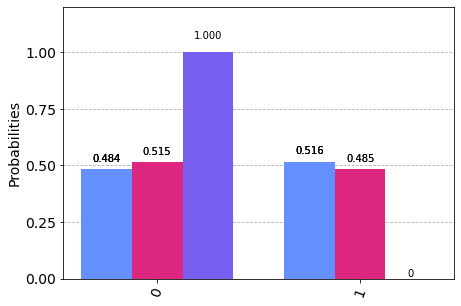

In [35]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

qc.ry(2 * np.arctan(np.sqrt(2)), 0)
qc.rx(np.pi/6, 0) 
qc.barrier()
## STEP 1
create_bell_pair(qc, 1, 2)

## STEP 2
qc.barrier() # Use barrier to separate steps
alice_gates(qc, 0, 1)

## STEP 3
measure_and_send(qc, 0, 1)

## STEP 4
qc.barrier() # Use barrier to separate steps
bob_gates(qc, 2, crz, crx)


## STEP 5
qc.rx(-np.pi/6, 2)
qc.ry(-2 * np.arctan(np.sqrt(2)), 2)
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.draw()
qc.measure(2,2)
print(qc)

sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, sim)
t_qc.save_statevector()
counts = sim.run(t_qc).result().get_counts()
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]
plot_histogram(qubit_counts)

#### (iii)

         ┌────────────┐┌─────────┐ ░            ░      ┌───┐ ░ ┌─┐    ░        »
    q_0: ┤ Ry(1.9106) ├┤ Rx(π/6) ├─░────────────░───■──┤ H ├─░─┤M├────░────────»
         └────────────┘└─────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░        »
    q_1: ──────────────────────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░────────»
                                   ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐ »
    q_2: ──────────────────────────░──────┤ X ├─░────────────░──╫──╫──░──┤ X ├─»
         ┌────────────┐┌─────────┐ ░      └───┘ ░            ░  ║  ║  ░  └─╥─┘ »
    q_3: ┤ Ry(1.9106) ├┤ Rx(π/6) ├─░────────────░────────────░──╫──╫──░────╫───»
         └────────────┘└─────────┘ ░            ░            ░  ║  ║  ░    ║   »
    q_4: ──────────────────────────░────────────░────────────░──╫──╫──░────╫───»
                                   ░            ░            ░  ║  ║  ░    ║   »
  crz: 1/═══════════════════════════════════════════════════════╩══╬═══════╬═══»
                            

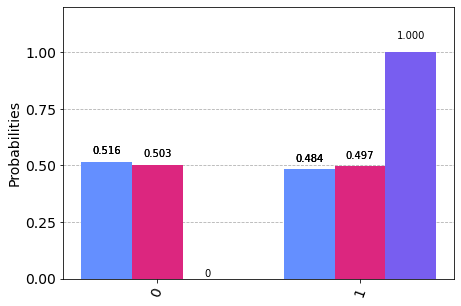

In [36]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(5, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

qc.ry(2 * np.arctan(np.sqrt(2)), 3)
qc.rx(np.pi/6, 3) 

qc.ry(2 * np.arctan(np.sqrt(2)), 0)
qc.rx(np.pi/6, 0) 
qc.barrier()
## STEP 1
create_bell_pair(qc, 1, 2)

## STEP 2
qc.barrier() # Use barrier to separate steps
alice_gates(qc, 0, 1)

## STEP 3
measure_and_send(qc, 0, 1)

## STEP 4
qc.barrier() # Use barrier to separate steps
bob_gates(qc, 2, crz, crx)
qc.initialize([1,0],2)
qc.initialize([1,0],3)
qc.h(4)
qc.cswap(4,2,3)
qc.h(4)
qc.x(4)

cr_result = ClassicalRegister(1,name="cswap")
qc.add_register(cr_result)
qc.measure(4,cr_result)
print(qc)
sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, sim)
t_qc.save_statevector()
counts = sim.run(t_qc).result().get_counts()
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]
plot_histogram(qubit_counts)

### 2(b)[3]

         ┌───┐      ░               ░      ┌───┐ ░ ┌─┐         
qbits_0: ┤ H ├──■───░───────────────░───■──┤ H ├─░─┤M├─────────
         └───┘┌─┴─┐ ░      ┌───┐    ░   │  └───┘ ░ └╥┘┌─┐      
qbits_1: ─────┤ X ├─░───■──┤ H ├─■──░───┼────────░──╫─┤M├──────
         ┌───┐└───┘ ░ ┌─┴─┐└───┘ │  ░   │        ░  ║ └╥┘┌─┐   
qbits_2: ┤ H ├──■───░─┤ X ├──■───┼──░───┼────────░──╫──╫─┤M├───
         └───┘┌─┴─┐ ░ └───┘┌─┴─┐ │  ░ ┌─┴─┐      ░  ║  ║ └╥┘┌─┐
qbits_3: ─────┤ X ├─░──────┤ X ├─■──░─┤ X ├──────░──╫──╫──╫─┤M├
              └───┘ ░      └───┘    ░ └───┘      ░  ║  ║  ║ └╥┘
cbits: 4/═══════════════════════════════════════════╩══╩══╩══╩═
                                                    0  1  2  3 


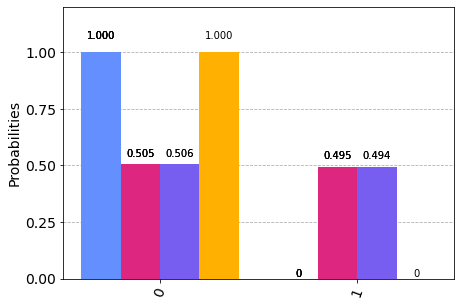

In [6]:

qbits = QuantumRegister(4, 'qbits')
cbits = ClassicalRegister(4, 'cbits')
sys = QuantumCircuit(qbits, cbits)

# creating bell-pairs
sys.h(qbits[0])
sys.cx(qbits[0], qbits[1])

sys.h(qbits[2])
sys.cx(qbits[2], qbits[3])

sys.barrier()

# # transferring one qubit to channel
# sys.swap(qbits[1], qbits[2])

sys.cx(qbits[1],qbits[2])
sys.h(qbits[1])
sys.cx(qbits[2],qbits[3])
sys.cz(qbits[1],qbits[3])
sys.barrier()

# checking fidelity with bell-basis measurement 
sys.cx(qbits[0], qbits[3])
sys.h(qbits[0])

sys.barrier()
sys.measure(qbits,cbits)
# measuring qubits
print(sys)
shots = 8192
sim = Aer.get_backend('aer_simulator')
t_qc = transpile(sys, sim)
t_qc.save_statevector()
counts = sim.run(t_qc).result().get_counts()
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(4)]
plot_histogram(qubit_counts)

# Q3[4]

In [7]:
from qiskit import *
from qiskit.visualization import plot_histogram
from numpy.random import randint
import numpy as np
from math import pi
import time

In [8]:
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Prepare qubit in Z-basis
            if bits[i] == 0:
                pass 
            else:
                qc.x(0)
        else: # Prepare qubit in X-basis
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

def encode_message_in_three_bases(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Prepare qubit in Z-basis
            if bits[i] == 0:
                pass 
            else:
                qc.x(0)
        elif bases[i] == 1: # Prepare qubit in X-basis
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        else:
            if bits[i] == 0:
                qc.h(0)
                qc.s(0)
            else:
                qc.x(0)
                qc.h(0)
                qc.s(0)
        qc.barrier()
        message.append(qc)
    return message


def measure_message(message, bases):
    backend = Aer.get_backend('aer_simulator')
    measurements = []
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        aer_sim = Aer.get_backend('aer_simulator')
        qobj = assemble(message[q], shots=1, memory=True)
        result = aer_sim.run(qobj).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

def intercept_message(message, bases):
    backend = Aer.get_backend('aer_simulator')
    measurements = []
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        aer_sim = Aer.get_backend('aer_simulator')
        qobj = assemble(message[q], shots=1, memory=True)
        result = aer_sim.run(qobj).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

def intercept_message_using_breidbart_basis(message, bases):
    backend = Aer.get_backend('aer_simulator')
    measurements = []
    for q in range(n):
        message[q].ry(-np.pi/4,0)
        message[q].measure(0,0)
        aer_sim = Aer.get_backend('aer_simulator')
        qobj = assemble(message[q], shots=1, memory=True)
        result = aer_sim.run(qobj).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements


def intercept_message_in_three_bases(message, bases):
    backend = Aer.get_backend('aer_simulator')
    measurements = []
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        if bases[q] == 2:
            message[q].sdg(0)
            message[q].h(0)
            message[q].measure(0,0)
        aer_sim = Aer.get_backend('aer_simulator')
        qobj = assemble(message[q], shots=1, memory=True)
        result = aer_sim.run(qobj).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

def intercept_message_the_best_in_three_bases(message, bases):
    backend = Aer.get_backend('aer_simulator')
    measurements = []
    for q in range(n): 
        message[q].rz(-np.pi/4,0)
        message[q].ry(-np.arccos(1/np.sqrt(3)),0)
        message[q].measure(0,0)
        aer_sim = Aer.get_backend('aer_simulator')
        qobj = assemble(message[q], shots=1, memory=True)
        result = aer_sim.run(qobj).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements


def remove_garbage(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            # If both used the same basis, add
            # this to the list of 'good' bits
            good_bits.append(bits[q])
    return good_bits

def sample_bits(bits, selection):
    sample = []
    for i in selection:
        # use np.mod to make sure the
        # bit we sample is always in 
        # the list range
        i = np.mod(i, len(bits))
        # pop(i) removes the element of the
        # list at index 'i'
        sample.append(bits.pop(i))
    return sample

In [9]:
np.random.seed(seed=round(time.time()))
n = 1000

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = intercept_message(message, eve_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
correct_bit = 0
for i in range(n):
    if(alice_bits[i] == intercepted_message[i]):
        correct_bit = correct_bit + 1
print("correct percentage: ", correct_bit/n*100, "%")

C:\Users\USER\anaconda3\envs\IBMQ\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


correct percentage:  75.0 %


In [10]:
np.random.seed(seed=round(time.time()))
n = 1000

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)

message = encode_message(alice_bits, alice_bases)

## Interception!!
eve_bases = randint(2, size=n)

intercepted_message = intercept_message_using_breidbart_basis(message, eve_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
correct_bit = 0
for i in range(n):
    if(alice_bits[i] == intercepted_message[i]):
        correct_bit = correct_bit + 1
print("correct percentage: ", correct_bit/n*100, "%")

correct percentage:  85.8 %


In [11]:
np.random.seed(seed=round(time.time()))
n = 1000

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(3, size=n)
message = encode_message_in_three_bases(alice_bits, alice_bases)

## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = intercept_message_in_three_bases(message, eve_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
correct_bit = 0
for i in range(n):
    if(alice_bits[i] == intercepted_message[i]):
        correct_bit = correct_bit + 1
print("correct percentage: ", correct_bit/n*100, "%")

correct percentage:  67.30000000000001 %


In [12]:
np.random.seed(seed=round(time.time()))
n = 1000
## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)
## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(3, size=n)
message = encode_message_in_three_bases(alice_bits, alice_bases)

## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = intercept_message_the_best_in_three_bases(message, eve_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
correct_bit = 0
for i in range(n):
    if(alice_bits[i] == intercepted_message[i]):
        correct_bit = correct_bit + 1
print("correct percentage: ", correct_bit/n*100, "%")

correct percentage:  76.8 %


## Reference

[1] https://qiskit.org/textbook/ch-algorithms/superdense-coding.html \
[2] https://qiskit.org/textbook/ch-algorithms/teleportation.html \
[3] https://github.com/SowmitraDas/Quantum-Repeater-using-Quantum-Circuits/blob/main/Elements%20-%20Entanglement%20Swapping.ipynb \
[4]https://qiskit.org/textbook/ch-algorithms/quantum-key-distribution.html